In [1]:
import veloxchem as vlx
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Molecule and basis set
h2o_xyz = """3
water
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        1.100000000000
"""

molecule = vlx.Molecule.read_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(molecule, "cc-pvdz", ostream=None)

In [3]:
# Run SCF
scf_drv = vlx.ScfRestrictedDriver()
scf_dict = {'conv_thresh': 1e-8}
scf_drv.ostream.mute()
scf_drv.update_settings(scf_dict)
scf_results = scf_drv.compute(molecule, basis)

In [4]:
# Some of the following variables will be useful later

# Number of orbitals, orbital energies, MO coefficients, ERIs in spatial MO basis (physicists' notation)
N_MO = scf_results["C_alpha"].shape[1]
N_O = molecule.number_of_electrons() // 2
N_V = N_MO - N_O
epsilon = scf_results["E_alpha"]
# epsilon_a - epsilon_i (as a 2D matrix)
epsilon_ov = epsilon[N_O:] - epsilon[:N_O].reshape(-1, 1)

# MO coefficients
C = scf_results["C_alpha"]
C_occ = C[:, :N_O]
C_vir = C[:, N_O:]

# ERI
moeridrv = vlx.MOIntegralsDriver()
eri_oovv = moeridrv.compute_in_memory(molecule, basis, mol_orbs = scf_drv.mol_orbs, moints_name = "chem_OOVV")
eri_ooov = moeridrv.compute_in_memory(molecule, basis, mol_orbs = scf_drv.mol_orbs, moints_name = "chem_OOOV")
eri_ovvv = moeridrv.compute_in_memory(molecule, basis, mol_orbs = scf_drv.mol_orbs, moints_name = "chem_OVVV")

In [5]:
def get_mp2_correction(molecule, basis, scf_drv):
    e_mp2_ss = 0.0
    e_mp2_os = 0.0

    # oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_memory(molecule, basis, mol_orbs=scf_drv.mol_orbs, moints_name="chem_OOVV")
  
    # extract the occupied subset of the orbital energies
    e_occ = scf_results["E_alpha"][:N_O]
    # extract the virtual subset of the orbital energies
    e_vir = scf_results["E_alpha"][N_O:]
    e_ab = e_vir + e_vir.reshape(-1, 1) # epsilon_a + epsilon_b (as 2D matrix)
    
    for i in range(N_O):
        for j in range(N_O):
            e_mp2_os -= np.sum((oovv[i, j] * oovv[i, j]) / (e_ab - e_occ[i] - e_occ[j]))
            e_mp2_ss -= np.sum((oovv[i, j] * (oovv[i, j] - oovv[i, j].T)) / (e_ab - e_occ[i] - e_occ[j]))
    

    return e_mp2_ss, e_mp2_os

In [6]:
# MP2 calculation using Vlx
mp2driver = vlx.mp2driver.Mp2Driver()
mp2driver.ostream.mute()
mp2driver.compute(molecule, basis, scf_drv.mol_orbs)
e_mp2_vlx = mp2driver.e_mp2

e_mp2_ss, e_mp2_os = get_mp2_correction(molecule, basis, scf_drv)

print("\n\nComparison to native VeloxChem routine:\n")
print(f"Opposite-spin MP2 energy: {e_mp2_os:20.12f} H.")
print(f"Same-spin MP2 energy:     {e_mp2_ss:20.12f} H.")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:20.12f} H.")
print(f"MP2 energy, vlx:          {e_mp2_vlx:20.12f} H.")



Comparison to native VeloxChem routine:

Opposite-spin MP2 energy:      -5.292550395109 H.
Same-spin MP2 energy:          -0.000000000000 H.
MP2 energy:                    -5.292550395109 H.
MP2 energy, vlx:               -0.208104435264 H.


In [7]:
def get_t_amplitudes(molecule, basis, scf_drv):
    #t_aaaa, t_abab, t_abba
    #t_bbbb, t_baba, t_baab
     
    # orbital energies and oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_memory(molecule, basis, mol_orbs=scf_drv.mol_orbs, moints_name="chem_OOVV")
     
    # extract the occupied subset of the orbital energies
    e_occ = scf_results["E_alpha"][:N_O]
    # extract the virtual subset of the orbital energies
    e_vir = scf_results["E_alpha"][N_O:]
    e_ab = e_vir + e_vir.reshape(-1, 1) # epsilon_a + epsilon_b (as 2D matrix)
          
    # Different spin blocks (a=alpha, b=beta)
    t2_aaaa = np.zeros((N_O, N_O, N_V, N_V))
    t2_abab = np.zeros((N_O, N_O, N_V, N_V))
    t2_abba = np.zeros((N_O, N_O, N_V, N_V))
    for i in range(N_O):
        for j in range(N_O):
            t2_aaaa[i,j] = (oovv[i, j] - eri_oovv[i, j].T) / (e_ab - e_occ[i] - e_occ[j])
            t2_abab[i,j] = (oovv[i, j]) / (e_ab - e_occ[i] - e_occ[j])
            t2_abba[j,i] = (- eri_oovv[j, i].T) / (e_ab - e_occ[i] - e_occ[j])
            
    t2_mp2 = {'aaaa': t2_aaaa, 'abab': t2_abab, 'abba': t2_abba}

    return t2_mp2

In [8]:
t2 = get_t_amplitudes(molecule, basis, scf_drv)

e_mp2 = -0.5*( np.einsum('ijab,ijab->', t2['aaaa'], eri_oovv)
          -np.einsum('ijab,ijba->', t2['aaaa'], eri_oovv)
          +np.einsum('ijab,ijab->', t2['abab'], eri_oovv)
          -np.einsum('ijab,ijba->', t2['abba'], eri_oovv) )

print("\nComparison to MP2 using same-spin, opposite-spin, and native VeloxChem routine:\n")
print(f"MP2 energy, t-amplitudes: {e_mp2:20.12f} H.")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:20.12f} H.")
print(f"MP2 energy, vlx:          {e_mp2_vlx:20.12f} H.")


Comparison to MP2 using same-spin, opposite-spin, and native VeloxChem routine:

MP2 energy, t-amplitudes:      -5.292550395109 H.
MP2 energy:                    -5.292550395109 H.
MP2 energy, vlx:               -0.208104435264 H.


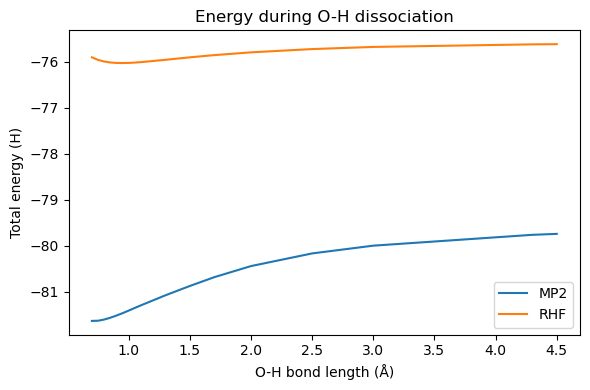

In [9]:
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

# list of bond distances
distlist = [0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.3,1.5,1.7,2,2.5,3,4.3,4.5]

# empty list for HF and MP2 energies
E_hf = []
E_mp2 = []

# SCF driver
scf_drv_pec = vlx.ScfRestrictedDriver()
scf_drv_pec.ostream.state = False # To disable the printout

for oh in distlist:
    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    molecule = vlx.Molecule.read_molecule_string(mol_str, units='angstrom')
    basis = vlx.MolecularBasis.read(molecule, "cc-pvdz", ostream=None)
    
    # Compute SCF energy
    scf_drv_pec.compute(molecule, basis)
    scf_drv.ostream.mute()
    E_hf.append(scf_drv_pec.get_scf_energy())
    
    #print("Calculating the energies for... %5.2f" % oh, " Å; converged? ", scf_drv_pec.is_converged)
    
    # Compute MP2 energy
    e_mp2_ss, e_mp2_os = get_mp2_correction(molecule, basis, scf_drv_pec)
    E_mp2.append(scf_drv_pec.get_scf_energy() + e_mp2_ss + e_mp2_os)

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Energy during O-H dissociation')
x = np.array(distlist)
y = np.array(E_mp2)
z = np.array(E_hf)

plt.plot(x,y, label='MP2')
plt.plot(x,z, label='RHF')
plt.xlabel('O-H bond length (Å)')
plt.ylabel('Total energy (H)')

plt.legend()
plt.tight_layout(); plt.show()

In [10]:
scf_density = scf_results['D_alpha'] + scf_results['D_beta']
prop = vlx.firstorderprop.FirstOrderProperties()
prop.compute(molecule, basis, scf_density)
hf_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(molecule, 'HF dipole moment')

                                                                                                                          
                                                     HF dipole moment                                                     
                                                    ------------------                                                    
                                                                                                                          
                                   X   :         0.000000 a.u.         0.000000 Debye                                     
                                   Y   :         0.548327 a.u.         1.393708 Debye                                     
                                   Z   :         4.327570 a.u.        10.999586 Debye                                     
                                 Total :         4.362170 a.u.        11.087530 Debye                                     
                

In [11]:
# occ-occ block
gamma_ij = - (np.einsum('ikab,jkab->ij', t2['aaaa'], t2['aaaa']) + np.einsum('ikab,jkab->ij', t2['abab'], t2['abab']) + np.einsum('ikab,jkab->ij', t2['abba'], t2['abba']))

# vir-vir block
gamma_ab = np.einsum('ijac,ijbc->ab', t2['aaaa'], t2['aaaa']) + np.einsum('ijac,ijbc->ab', t2['abab'], t2['abab']) + np.einsum('ijac,ijbc->ab', t2['abba'], t2['abba'])

# Transform to AO basis
gamma_ao = np.linalg.multi_dot([C_occ, gamma_ij, C_occ.T]) + np.linalg.multi_dot([C_vir, gamma_ab, C_vir.T])

# Add SCF density and calculate dipole moment
unrelaxed_density = scf_density + gamma_ao
prop.compute(molecule, basis, unrelaxed_density)
ur_mp2_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(molecule, 'Unrelaxed MP2 dipole moment')

                                                                                                                          
                                               Unrelaxed MP2 dipole moment                                                
                                              -----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :        -0.144840 a.u.        -0.368148 Debye                                     
                                   Z   :        -4.857150 a.u.       -12.345644 Debye                                     
                                 Total :         4.859309 a.u.        12.351132 Debye                                     
                

In [12]:
term1 = -(2 * np.einsum('jkab,jkib->ia', t2['abab'], eri_ooov)
            - np.einsum('jkab,kjib->ia', t2['abab'], eri_ooov)
         )
term2 = (2 * np.einsum('ijbc,jacb->ia', t2['abab'], eri_ovvv)
           - np.einsum('ijbc,jabc->ia', t2['abab'], eri_ovvv)
         )

lambda_ov = (term1 + term2) / epsilon_ov

lambda_ao = ( np.linalg.multi_dot([C_occ, lambda_ov, C_vir.T])
            + np.linalg.multi_dot([C_vir, lambda_ov.T, C_occ.T])
            )

prop.compute(molecule, basis, unrelaxed_density + 2 * lambda_ao)
rel_mp2_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(molecule, 'Approx. relaxed MP2 dipole moment')

                                                                                                                          
                                            Approx. relaxed MP2 dipole moment                                             
                                           -----------------------------------                                            
                                                                                                                          
                                   X   :         0.000000 a.u.         0.000000 Debye                                     
                                   Y   :        -0.244572 a.u.        -0.621639 Debye                                     
                                   Z   :        -5.582698 a.u.       -14.189804 Debye                                     
                                 Total :         5.588053 a.u.        14.203414 Debye                                     
                

In [13]:
# SCF driver for positive field direction
scf_drv_p = vlx.ScfRestrictedDriver()
scf_drv_p.ostream.mute()
# Define external electric field
method_dict_p = {'electric_field': '0,0,0.00001'}
# Update the settings with the electric field
scf_drv_p.update_settings(scf_dict, method_dict_p)
# Compute SCF energy in presence of external field
scf_drv_p.compute(molecule, basis)
hf_e_p = scf_drv_p.get_scf_energy()
# Use MP2 driver from Vlx
mp2driver.compute(molecule, basis, scf_drv_p.mol_orbs)
# Sum up the energies
mp2_e_p = hf_e_p + mp2driver.e_mp2

# Repeat with a field in negative z direction
scf_drv_m = vlx.ScfRestrictedDriver()
scf_drv_m.ostream.mute()
method_dict_m = {'electric_field': '0,0,-0.00001'}
scf_drv_m.update_settings(scf_dict, method_dict_m)
scf_drv_m.compute(molecule, basis)
hf_e_m = scf_drv_m.get_scf_energy()
mp2driver.compute(molecule, basis, scf_drv_m.mol_orbs)
mp2_e_m = hf_e_m + mp2driver.e_mp2

# Calculate the z component dipole moment numerically
field_strength = float(method_dict_p['electric_field'].split(",")[-1])
hf_mu_z = - (hf_e_p - hf_e_m) / (2 * field_strength)
mp2_mu_z = - (mp2_e_p - mp2_e_m) / (2 * field_strength)

print("Analytical HF mu_z: %10.5f a.u." % hf_dipole_moment[-1])
print("Numerical HF  mu_z: %10.5f a.u." % hf_mu_z)
print()
print("Unrelaxed MP2   mu_z: %10.5f a.u." % ur_mp2_dipole_moment[-1])
print("Approximate MP2 mu_z: %10.5f a.u." % rel_mp2_dipole_moment[-1])
print("Numerical MP2   mu_z: %10.5f a.u.\n" % mp2_mu_z)

Analytical HF mu_z:    4.32757 a.u.
Numerical HF  mu_z:    0.36478 a.u.

Unrelaxed MP2   mu_z:   -4.85715 a.u.
Approximate MP2 mu_z:   -5.58270 a.u.
Numerical MP2   mu_z:   -0.09314 a.u.

